In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

In [2]:
url = 'https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip'
zip_path = 'sms_spam_collection.zip'
extracted_path = 'sms_spam_collection'
data_file_path = Path(extracted_path) / 'SMSSpamCollection.tsv'

def download_and_unzip_spam_data(url: str, zip_path: str, extracted_path: str, data_file_path: Path) -> None:
    """下载并解压数据集

    Args:
        url (str): 下载地址
        zip_path (str): 压缩文件名
        extracted_path (str): 解压地址
        data_file_path (Path): 数据集地址
    """
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction")
        return
    
    # 下载文件
    with urllib.request.urlopen(url=url) as response:
        with open(zip_path, 'wb') as out_file:
            out_file.write(response.read())
    
    # 解压文件
    with zipfile.ZipFile(file=zip_path) as zip_ref:
        zip_ref.extractall(extracted_path)
    
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saveed as {data_file_path}")

download_and_unzip_spam_data(url=url, zip_path=zip_path, extracted_path=extracted_path, data_file_path=data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction


In [3]:
import pandas as pd
from pandas.core.frame import DataFrame
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [4]:
# DataFrame.value_counts()可以查看数据的分布情况，基于分布情况需要创建一个平衡数据集
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
def create_balanced_dataset(df: DataFrame) -> DataFrame:
    """创建平衡数据集

    Args:
        df (DataFrame): 原始数据集

    Returns:
        DataFrame: 平衡数据集
    """
    num_spam = df[df['Label'] == 'spam'].shape[0]
    # 随机采样 ham 使其数量与 spam一致 这里先获取df的label列中值为ham的index，再通过df[[indexs]]读取数据，利用sample从这一批数据中随机抽样num_spam个样本
    ham_subset = df[df['Label'] == 'ham'].sample(num_spam, random_state=123)
    balanced_df = pd.concat([
        ham_subset, df[df['Label'] == "spam"]
    ]) # 拼接全部spam数据和随机采样与spam相同数量的ham数据集
    return balanced_df
balanced_df = create_balanced_dataset(df)
balanced_df['Label'].value_counts()

Label
ham     747
spam    747
Name: count, dtype: int64

In [6]:
# 转换文本为整数类别标签
balanced_df['Label'] = balanced_df['Label'].map({"ham": 0, "spam": 1})
balanced_df['Label']

4307    0
4138    0
4831    0
4461    0
5440    0
       ..
5537    1
5540    1
5547    1
5566    1
5567    1
Name: Label, Length: 1494, dtype: int64

In [7]:
def random_split(df: DataFrame, train_frac: float, validation_frac: float) -> tuple[DataFrame, DataFrame, DataFrame]:
    """拆分训练集、验证集和测试集

    Args:
        df (DataFrame): 数据框
        train_frac (float): 训练集比例
        validation_frac (float): 验证集比例

    Returns:
        tuple[DataFrame, DataFrame, DataFrame]: 完整数据集
    """
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) # 重新设置索引
    train_end = int(len(df) * train_frac) # 训练集结束索引位置
    validation_end = train_end + int(len(df) * validation_frac) # 验证集结束索引位置
    
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [8]:
from torch.utils.data import Dataset, DataLoader
import tiktoken
from tiktoken.core import Encoding
import torch

class SpamDataset(Dataset):
    """填充长度不足序列Dataset

    Args:
        Dataset (Dataset): PyTorch Dataset
    """
    def __init__(self, csv_file: str, tokenizer: Encoding, max_length: int, pad_token_id: int = 50256):
        """构造函数，加载数据集、对数据集进行编码、对超过最大长度的截断，不足最大长度的填充

        Args:
            csv_file (str): csv 数据集路径
            tokenizer (Encoding): 编码器
            max_length (int): 最大长度
            pad_token_id (int, optional): _description_. Defaults to 50256.
        """
        super().__init__()
        self.data = pd.read_csv(filepath_or_buffer=csv_file) # 读取数据集
        self.encoded_texts = [ tokenizer.encode(text=text) for text in self.data["Text"] ] # 文本分词编码
        
        if max_length is None:
            self.max_length = self._longest_encoded_length() # 没有设置最大长度 获取最大长度
        else:
            # 序列长度超过设置的max_length长度则截断
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts]
        
        self.encoded_texts = [ encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts ] # 填充序列到最大长度
    
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long).to("cuda"),
            torch.tensor(label, dtype=torch.long).to("cuda")
        )
        
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self) -> int:
        """获取编码数据集中最长序列

        Returns:
            int: 最大长度
        """
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

tokenizer = tiktoken.get_encoding("gpt2")
# 加载数据
train_dataset = SpamDataset(csv_file="train.csv", max_length=None, tokenizer=tokenizer)
val_dataset = SpamDataset(csv_file="validation.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)
test_dataset = SpamDataset(csv_file="test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer)

In [9]:
# 创建数据加载器
batch_size = 8
num_workers= 0
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

for input_batch, target_batch in train_dataloader:
    pass
print("Input Batch dimensions:", input_batch.shape)
print("Label Batch dimensions:", target_batch.shape)

Input Batch dimensions: torch.Size([8, 120])
Label Batch dimensions: torch.Size([8])


In [10]:
# 准备模型配置
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}
model_configs = {
    "gpt2-small (124M)":  {"emb_dim": 768,  "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)":  {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)":    {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
# 加载参数到模型
from GPTModel import GPTModel2, load_weights_into_gpt, generate, text_to_token_ids, token_ids_to_text
from gpt_download import download_and_load_gpt2
import tiktoken

model_size = CHOOSE_MODEL.split(" ")[-1].strip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel2(BASE_CONFIG) # 初始化模型
load_weights_into_gpt(model, params) # 加载参数
model.eval() # 模型进入评估模式
model.to("cuda")

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text=INPUT_PROMPT, tokenizer=tokenizer),
    context_size=BASE_CONFIG['context_length'],
    max_new_tokens=15
)
token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)

2026-01-14 14:46:56.077518: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-14 14:46:56.762506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-14 14:46:58.836011: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe
Output text:
 Hello there you two – I think it's too early to draw any specific conclusions or conclusions about where Trump may be taking you.

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File a

'Every effort moves forward, but it\'s not enough.\n\n"I\'m not going'

In [11]:
from torch import nn
# 添加分类头
model # 查看模型架构
# 冻结层（不进行反向传播，不存储梯度）
for param in model.parameters():
    param.requires_grad = False
# 替换最终输出层
model.out_head = nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=2).requires_grad_(True)
# 解冻最终层归一化以及最后一个Transformer块
for param in model.transformer_blocks[-1].parameters(): # 遍历最后一层Transformer块的参数并解冻
    param.requires_grad = True
for param in model.final_norm.parameters(): # 遍历最后层归一化全部参数并解冻
    param.requires_grad = True

In [12]:
from tqdm.notebook import tqdm

def classification_fine_tuning(
    model: nn.Module,
    train_dataloader: DataLoader,
    test_dataloader: DataLoader,
    lr: float,
    batch_size: int,
    num_epochs: int
) -> tuple[list[float], list[float], list[float], list[float]]:
    """分类微调

    Args:
        model (nn.Module): 模型
        train_features (torch.Tensor): 训练特征
        train_labels (torch.Tensor): 训练labels
        test_features (torch.Tensor): 测试特征
        test_labels (torch.Tensor): 测试labels
        lr (float): 学习率
        batch_size (int): 批次大小
        num_epochs (int): 迭代次数

    Returns:
        tuple[list[float], list[float], list[float], list[float]]: 训练损失、测试损失、训练准确率、测试准确率
    """
    model.to("cuda")
    
    train_loss, test_loss = [], [] # 训练损失及测试损失
    train_accuracy, test_accuracy = [], [] # 训练准确度及测试准确度
    
    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
    lossf = nn.CrossEntropyLoss()
    
    tqdm_instance = tqdm(range(num_epochs), desc="训练中")
    for _ in tqdm_instance:
        model.train() # 启用训练模式
        train_loss_sum, test_loss_sum = 0, 0 # 训练损失之和、测试损失之和
        true_preds = 0 # 预测正确数
        # 训练集训练
        for X, y in train_dataloader:
            optim.zero_grad()
            out = model(X)
            print(X.shape, y.shape, out.shape)
            # 计算每个批次的平均准确率
            # true_preds += (torch.argmax(out, dim=1) == y).float().mean().item()
            l: torch.Tensor = lossf(out, y)
            # 计算当前批次损失之和
            train_loss_sum += l.item()
            l.backward()
            optim.step()
        # 计算每次迭代的训练平均准确率
        train_accuracy.append(true_preds / len(train_dataloader))
        # 计算每次迭代的训练平均损失
        train_loss.append(train_loss_sum / len(train_dataloader))
        
        # 测试集评估
        true_preds = 0
        for X, y in test_dataloader:
            out = model(X)
            # true_preds += (torch.argmax(out, dim=1) == y).float().mean().item()
                
            lt: torch.Tensor = lossf(out, y)
            test_loss_sum += lt.item()
        test_loss_mean = test_loss_sum / len(test_dataloader)
        test_loss.append(test_loss_mean)
        test_accuracy.append(true_preds / len(test_dataloader))
    
    return train_loss, test_loss, train_accuracy, test_accuracy

In [13]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rsplit(")")
inputs = torch.tensor(tokenizer.encode("Do you have time")).to("cuda")
print(inputs.shape)
inputs = inputs.unsqueeze(0) # unsqueeze用于在现有张量上增加一个大小为1的维度，0表示当前张量的第一个位置上增加维度，1表示在第二个轴上增加
print(inputs.shape)

torch.Size([4])
torch.Size([1, 4])


In [14]:
# 测试架构更改后的模型
with torch.no_grad(): # with torch.no_grad()是PyTorch的上下文管理器，在指定代码块中禁用梯度计算
    model.to("cuda")
    outputs = model(inputs)
outputs.shape
print(f"useful output:{outputs[:, -1:, :]}")

useful output:tensor([[[5.9819, 0.3303]]], device='cuda:0')


In [15]:
def get_outputs(outputs: torch.Tensor) -> float:
    """获取分类Labels

    Args:
        outputs (torch.Tensor): llm output

    Returns:
        float: 分类Labels
    """
    logits = outputs[:, -1:, :]
    probas = torch.softmax(logits, dim=-1)
    labels = torch.argmax(probas)
    return labels.item()

In [16]:
def calc_accuracy_loader(data_loader: DataLoader, model: GPTModel2, device: str, num_batches: int = None) -> float:
    """计算分类准确率

    Args:
        data_loader (DataLoader): 数据加载器
        model (GPTModel2): GPT2模型
        device (str): 设备
        num_batches (int, optional): 批次大小. Defaults to None.

    Returns:
        float: 准确率
    """
    model.eval()
    correction_predictions, num_examples = 0, 0 # 定义正确预测数量和样本总数
    
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch  = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            
            num_examples += predicted_labels.shape[0] # 批次大小
            correction_predictions += ((predicted_labels == target_batch).sum().item()) # 批次中预测正确的数据
        else:
            break
    return correction_predictions / num_examples

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_dataloader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(train_dataloader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(train_dataloader, model, device, num_batches=10)

print(f"Trainning Accuracy:{train_accuracy*100:2f}%")
print(f"Validation Accuracy:{val_accuracy*100:2f}%")
print(f"Testing Accuracy:{test_accuracy*100:2f}%")

Trainning Accuracy:53.750000%
Validation Accuracy:53.750000%
Testing Accuracy:56.250000%


In [18]:
def calc_loss_batch(input_batch: torch.Tensor, target_batch: torch.Tensor, model: nn.Module, device: str) -> torch.Tensor:
    """计算单个批次的交叉熵损失

    Args:
        input_batch (torch.Tensor): 输入
        target_batch (torch.Tensor): 目标
        model (nn.Model): 模型
        device (str): 计算设备

    Returns:
        torch.Tensor: 损失
    """
    input_batch  = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # 最后一个输出词元的logits
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [19]:
def calc_loss_loader(data_loader: DataLoader, model: nn.Module, device: str, num_batchs: int = None) -> float:
    """计算全部批次的交叉熵损失

    Args:
        data_loader (DataLoader): 数据加载器
        model (nn.Module): 模型
        device (str): 设备
        num_batchs (int, optional): 批次大小. Defaults to None.

    Returns:
        float: 整体平均损失
    """
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batchs is None:
        num_batchs = len(data_loader)
    else:
        num_batchs = min(num_batchs, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batchs:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batchs

with torch.no_grad():
    train_loss = calc_loss_loader(data_loader=train_dataloader, model=model, device="cuda", num_batchs=5)
    val_loss = calc_loss_loader(data_loader=val_dataloader, model=model, device="cuda", num_batchs=5)
    test_loss = calc_loss_loader(data_loader=test_dataloader, model=model, device="cuda", num_batchs=5)
print(f"Trainning Loss:{train_loss:.3f}")
print(f"Validation Loss:{val_loss:.3f}")
print(f"Testing Loss:{test_loss:.3f}")

Trainning Loss:3.165
Validation Loss:4.423
Testing Loss:4.238


In [20]:
def evaluate_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, device: str, eval_iter: int) -> tuple[float, float]:
    """评估模型

    Args:
        model (nn.Module): 模型
        train_loader (DataLoader): 训练数据加载器
        val_loader (DataLoader): 验证数据加载器
        device (str): 设备
        eval_iter (int): 迭代次数

    Returns:
        tuple[float, float]: 训练损失，验证损失
    """
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(data_loader=train_loader, model=model, device=device, num_batchs=eval_iter)
        val_loss = calc_loss_loader(data_loader=val_loader, model=model, device=device, num_batchs=eval_iter)
    model.train()
    return train_loss, val_loss

In [21]:
def train_classifier_simple(
    model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, optimizer: torch.optim.Optimizer, device: str, num_epochs: int, eval_freq: int, eval_iter: int
) -> tuple[list[float], list[float], list[float], list[float], int]:
    """训练模型

    Args:
        model (nn.Module): 模型
        train_loader (DataLoader): 训练集数据加载器
        val_loader (DataLoader): 验证集数据加载器
        optimizer (torch.optim.Optimizer): 优化器
        device (str): 设备
        num_epochs (int): 迭代次数
        eval_freq (int): 评估频率
        eval_iter (int): 评估批次

    Returns:
        tuple[list[float], list[float], list[float], list[float], int]: 训练损失，验证损失，训练准确率，验证准确率，样本数
    """
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            # 计算损失
            loss = calc_loss_batch(input_batch=input_batch, target_batch=target_batch, model=model, device=device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model=model, train_loader=train_loader, val_loader=val_loader, device=device, eval_iter=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}):" f"Train Loss {train_loss:.3f}, " f"Val Loss {val_loss:.3f}")
        
        # 每轮训练后计算准确率
        train_accuracy = calc_accuracy_loader(data_loader=train_dataloader, model=model, num_batches=eval_iter, device=device)
        val_accuracy = calc_accuracy_loader(data_loader=val_loader, model=model, num_batches=eval_iter, device=device)
        
        print(f"Traning accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, example_seens = train_classifier_simple(model=model, train_loader=train_dataloader, val_loader=val_dataloader, optimizer=optimizer, num_epochs=num_epochs, device="cuda", eval_freq=50, eval_iter=5)

Ep 1 (Step 000000):Train Loss 2.842, Val Loss 4.857
Ep 1 (Step 000050):Train Loss 0.658, Val Loss 0.611
Ep 1 (Step 000100):Train Loss 0.515, Val Loss 0.528
Traning accuracy: 92.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150):Train Loss 0.404, Val Loss 0.329
Ep 2 (Step 000200):Train Loss 0.179, Val Loss 0.195
Ep 2 (Step 000250):Train Loss 0.144, Val Loss 0.120
Traning accuracy: 92.50% | Validation accuracy: 95.00%
Ep 3 (Step 000300):Train Loss 0.058, Val Loss 0.066
Ep 3 (Step 000350):Train Loss 0.121, Val Loss 0.062
Traning accuracy: 97.50% | Validation accuracy: 97.50%
Ep 4 (Step 000400):Train Loss 0.202, Val Loss 0.038
Ep 4 (Step 000450):Train Loss 0.015, Val Loss 0.330
Ep 4 (Step 000500):Train Loss 0.047, Val Loss 0.009
Traning accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550):Train Loss 0.033, Val Loss 0.042
Ep 5 (Step 000600):Train Loss 0.016, Val Loss 0.151
Traning accuracy: 100.00% | Validation accuracy: 100.00%


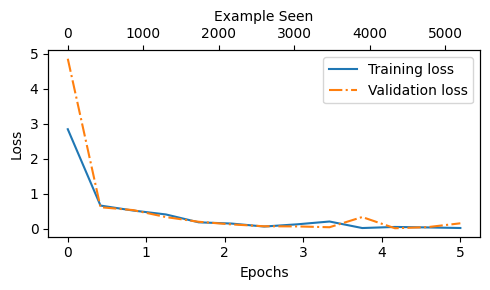

In [27]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen: torch.Tensor, example_seens: torch.Tensor, train_values: list[float], val_values: list[float], label: str="loss") -> None:
    """绘制曲线

    Args:
        epochs_seen (torch.Tensor): 训练轮数
        example_seens (torch.Tensor): 样本数
        train_values (list[float]): 训练记录值（损失/准确率）
        val_values (list[float]): 验证记录值（损失/准确率）
        label (str, optional): Y轴Labels. Defaults to "loss".
    """
    
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    
    ax2 = ax1.twiny() # 为所见样本创建第二个x轴
    ax2.plot(example_seens, train_values, alpha=0) # 不可见图形（X轴）用于对齐刻度
    ax2.set_xlabel("Example Seen")
    
    fig.tight_layout() # 调整布局腾出空间
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seens, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

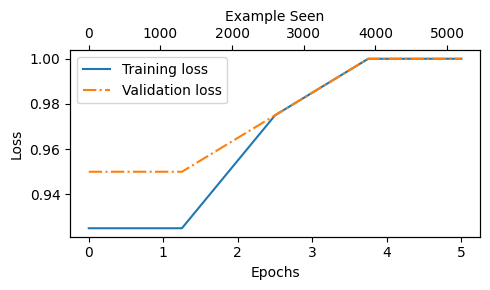

In [26]:
# 绘制准确率曲线
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, example_seens, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs)